Bulk objects inspection; apply GAIA->LS filter transformation

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    # plt.grid(alpha=0.5, lw=0.5)
    return ax

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_center, bin_median, bin_spread = np.zeros((3, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.median(x[mask])
        if np.sum(mask)>0:
            bin_median[index] = np.median(y[mask])
            bin_spread[index] = nmad(y[mask])
        else:
            bin_median[index], bin_spread[index] = np.nan, np.nan
    return bin_center, bin_median, bin_spread

-------

In [4]:
# gaia1 and gaia2: DECaLS/DES SGC; gaia3: BASS/MzLS; gaia4: DECaLS NGC
gaia_fn = 'gaia3.fits.gz'
gaia = Table.read('/Users/rongpu/Documents/Data/desi_misc/gaia_from_arjun/'+gaia_fn)
print(len(gaia))

if (gaia_fn=='gaia1.fits.gz') or (gaia_fn=='gaia2.fits.gz'):
    mask = gaia['dec']<31.
    gaia = gaia[mask]
    print(len(gaia))
                                  
if (gaia_fn=='gaia3.fits.gz'):
    mask = gaia['dec']>32.375
    gaia = gaia[mask]
    print(len(gaia))

568011
495651


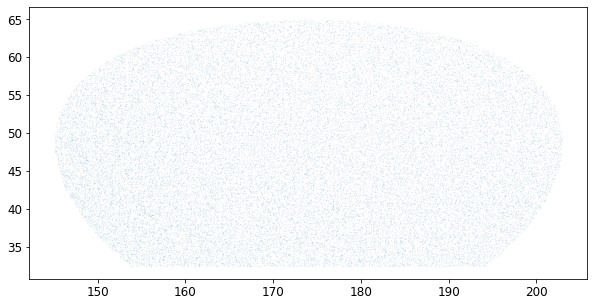

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(gaia['ra'][::10], gaia['dec'][::10], '.', ms=0.1, alpha=0.5)
plt.show()

In [6]:
# Remove duplicates
if len(np.unique(gaia['source_id']))<len(gaia):
    print('Duplicates exist!')
    gaia.sort('source_id')
    mask = gaia['source_id'][1:]==gaia['source_id'][:-1]
    mask = np.concatenate([[False], mask])
    gaia = gaia[~mask]
    
# Remove objects with invalide mask = np.isfinite(gaia['bp_rp'])
mask = np.isfinite(gaia['bp_rp'])
if np.sum(~mask)>0:
    print('{} objects with invalid bp_rp'.format(np.sum(~mask)))
    gaia = gaia[mask]

5136 objects with invalid bp_rp


In [7]:
gaia[:3]

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mag,mag,km / s,km / s,,K,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,bytes13,float32,float32
853541947406479744,158.26593562467318,0.03485320287322467,55.35971573170396,0.061919648554692064,0.8146031077626624,0.07291789071204319,-8.058321254772189,0.08080534331873265,0.2477227441667279,0.1352096814770408,0.0,16.38071,1.0068865,nan,nan,NOT_AVAILABLE,5311.0,0.0827
853458659400731264,157.77886322969965,0.03370989785815359,54.75301079799344,0.0464981968742596,1.3162084441101964,0.0658115814422006,9.059418922794379,0.08051547904775,-16.141389245067316,0.09522082384157327,0.0,16.409018,1.6684551,nan,nan,NOT_AVAILABLE,4196.885,0.8823
853544593106335616,158.11693668428555,0.03641127032271789,55.3434815026328,0.0611541710892731,0.2908630497077539,0.07479164658708168,-2.972697524514362,0.08379276205984086,-1.7201072545497695,0.11639660063958392,0.0,16.458794,0.8476572,nan,nan,NOT_AVAILABLE,5780.5,0.735


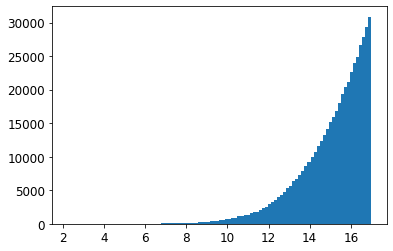

In [8]:
plt.hist(gaia['phot_g_mean_mag'], 100);

In [9]:
# Apply GAIA-LS transformation
from scipy.interpolate import interp1d
transform_interp = {}
for band in ['g', 'r', 'z']:
    tmp = np.load('data/gaia_bassmzls_{}_transform.npz'.format(band))
    bin_center, bin_median, bin_spread = tmp['arr_0'], tmp['arr_1'], tmp['arr_2']
    transform_interp[band] = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')
    gaia['ls_'+band] = gaia['phot_g_mean_mag'] + transform_interp[band](gaia['bp_rp'])

------
## Narrow bin of DECaLS g-band magnitude

In [10]:
ls_mag_min_list = [10.5, 13.0, 15.5]
ls_mag_max_list = [10.51, 13.01, 15.51]

In [11]:
radius_in_bin = []
flux_in_bin = []

for mag_index in range(len(ls_mag_min_list)):
        
    ls_mag_min, ls_mag_max = ls_mag_min_list[mag_index], ls_mag_max_list[mag_index]
    print('\n', '{} < {} < {}'.format(ls_mag_min, band, ls_mag_max))
    
    plot_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/plots/03/'    
    band = 'z'
    # img_type = '-resid'
    img_type = ''
    pixscale_str = '0.262'
    pixscale = float(pixscale_str)

    nsamp = 50

    idx = np.where((gaia['ls_'+band]>ls_mag_min) & (gaia['ls_'+band]<ls_mag_max))[0]
    print(len(idx))
    if len(idx)>nsamp:
        np.random.seed(1)
        idx = np.random.choice(idx, size=nsamp, replace=False)
        # print(len(idx))

    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
    radius_arr = []
    flux_arr = []

    for index in idx:

        print('phot_g_mean_mag = ', gaia['phot_g_mean_mag'][index])

        ra, dec = gaia['ra'][index], gaia['dec'][index]

        download_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/512/'
        file_path = os.path.join(download_dir, gaia_fn[:-8], 'gaia_{}_{}{}_{}.fits'.format(index, band, img_type, pixscale_str))
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))

        if not os.path.isfile(file_path):
            url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8{}&pixscale={}&bands={}&size=512'.format(ra, dec, img_type, pixscale_str, band)
            cmd = 'wget -O '+file_path+' \"'+url+'\"'
            print(cmd)
            os.system(cmd)

        img_raw = fitsio.read(file_path)
        img = img_raw / (pixscale**2)

        grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
        xx, yy = np.meshgrid(grid, grid)
        radius = np.sqrt(xx**2 + yy**2).flatten()
        max_radius = xx.flatten().max() # maximum radius before hitting the edge of the image

        # Remove masked pixels
        mask = img.flatten()!=0
        radius = radius[mask]
        flux = img.flatten()[mask]

        bin_center, bin_median, bin_spread = binned_stats(radius, flux, bins=np.linspace(0., np.floor(max_radius), np.floor(max_radius)+1))
        radius_arr.append(bin_center)
        flux_arr.append(bin_median)

    radius_arr = np.array(radius_arr)
    flux_arr = np.array(flux_arr)
    
    x, y, _ = binned_stats(radius_arr.flatten(), flux_arr.flatten(), bins=np.linspace(0., np.floor(max_radius), np.floor(max_radius)+1))
    radius_in_bin.append(x)
    flux_in_bin.append(y)


 10.5 < z < 10.51
99
phot_g_mean_mag =  10.7630005
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_461520_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=189.296282&dec=61.409035&layer=dr8&pixscale=0.262&bands=z&size=512"


/Users/rongpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


phot_g_mean_mag =  10.65912
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_416668_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=153.913594&dec=59.808592&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  10.543236
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_147972_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=151.394409&dec=39.771716&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  10.633183
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_398111_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=201.950271&dec=47.356945&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  11.00949
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_396333_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=180.736152&dec=40.798581&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  10.9383745
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/ga

phot_g_mean_mag =  11.804301
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_117060_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=163.769617&dec=47.241025&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  11.029027
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_160248_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=178.767385&dec=52.067529&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  11.023505
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_422318_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=187.111958&dec=47.940171&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  10.831316
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_471238_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=190.388410&dec=41.088678&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  11.0917845
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/

/Users/rongpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



 13.0 < z < 13.01
454
phot_g_mean_mag =  13.240219
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_75789_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=179.187653&dec=64.598119&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.146412
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_153724_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=175.605403&dec=49.990233&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.194694
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_403306_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=195.081883&dec=58.887120&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.197197
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_262791_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=191.143980&dec=33.192199&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.302261
wget -O /Users/rongpu/Downloads/g

phot_g_mean_mag =  13.235699
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_26407_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=177.556855&dec=43.727478&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.152328
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_166592_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=169.768646&dec=52.137009&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.253353
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_74581_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=159.486932&dec=40.120340&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.36468
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_143255_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=168.495920&dec=48.855093&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.197433
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia

phot_g_mean_mag =  16.11535
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_68729_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=166.045096&dec=42.069534&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  16.222158
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_245459_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=153.960897&dec=33.551035&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  15.8402405
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_359456_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=183.019103&dec=56.320901&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  15.874962
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia3/gaia_418199_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=176.046876&dec=34.311848&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  15.957023
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/ga

In [41]:
# t = Table()
# t['radius'] = radius_in_bin[0]
# for index in range(len(flux_in_bin)):
#     t['flux_{}_{:.2f}'.format(band, ls_mag_min_list[index])] = flux_in_bin[index]
# mask = t['radius']>=95.5
# t = t[~mask]

# t.write('data/BASSMZLS_profiles_{}.txt'.format(band), format='ascii.commented_header')

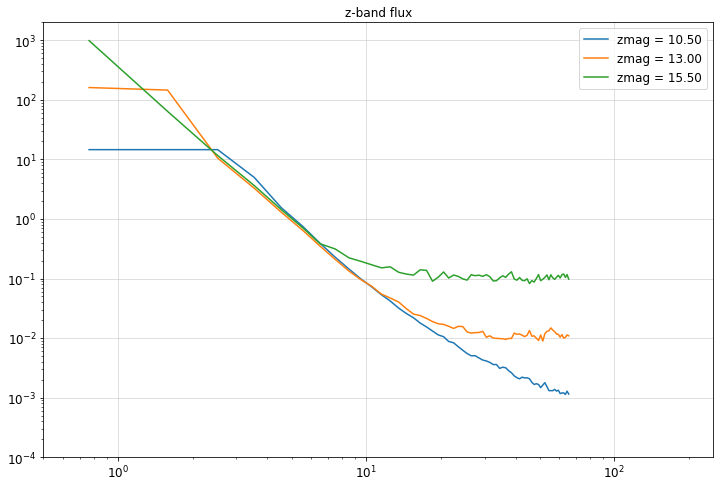

In [12]:
plt.figure(figsize=(12, 8))
for index in range(len(flux_in_bin)):
    # normalize the flux to 13th magnitude stars
    norm = 10**((ls_mag_min_list[index]-13)/2.5)
    plt.loglog(radius_in_bin[index], flux_in_bin[index]*norm, lw=1.5, alpha=1., 
               label='{}mag = {:.2f}'.format(band, ls_mag_min_list[index]))
plt.title('{}-band flux'.format(band))

plt.axis([.5, 250, .0001, 2000])
plt.grid(alpha=0.5)
plt.legend()
plt.show()

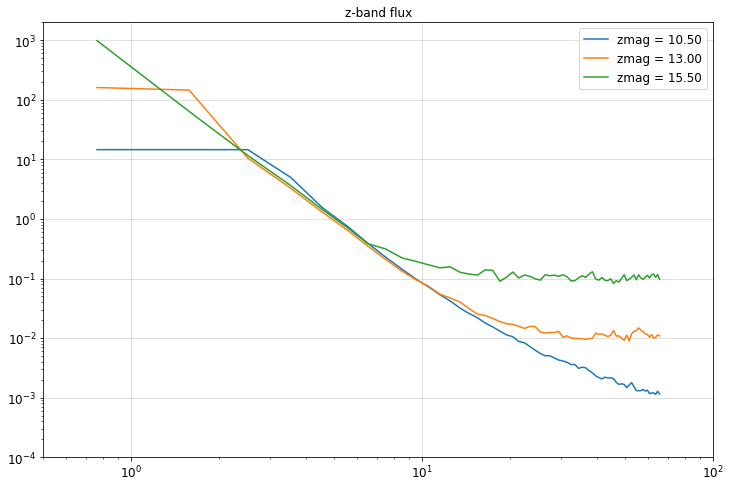

In [13]:
plt.figure(figsize=(12, 8))
for index in range(len(flux_in_bin)):
    # normalize the flux to 13th magnitude stars
    norm = 10**((ls_mag_min_list[index]-13)/2.5)
    plt.loglog(radius_in_bin[index], flux_in_bin[index]*norm, lw=1.5, alpha=1., 
               label='{}mag = {:.2f}'.format(band, ls_mag_min_list[index]))
plt.title('{}-band flux'.format(band))
plt.axis([.5, 100, .0001, 2000])
plt.grid(alpha=0.5)
plt.legend()
plt.show()

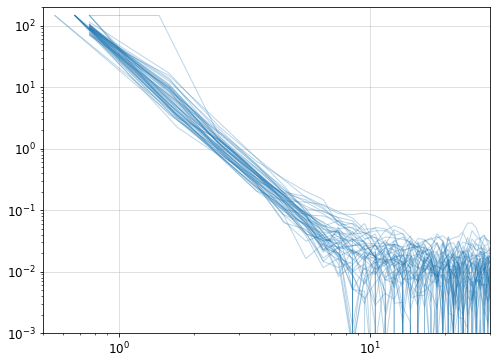

In [14]:
plt.figure(figsize=(8, 6))
plt.loglog(radius_arr.T, flux_arr.T, lw=1, alpha=0.3, c='C0')
plt.axis([.5, 30, .001, 200])
plt.grid(alpha=0.5)
# x0, _, y0, _ = binned_stats(radius_arr.flatten(), flux_arr.flatten(), bins=np.linspace(0., 31., 63))
# plt.loglog(x0, y0, lw=4, alpha=0.7, c='C1')
plt.show()